# Klavivo-Take-home-Challenge

* Mail: wchsu3@illinois.edu
* Name: Wei-Chieh Hsu
* Date: 04/16/2019

In [13]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

# Data Preprocessiong
### First I would check the data structure and whether there are missing values.

In [14]:
data = pd.read_csv('./screening_exercise_orders_v201810.csv', parse_dates=['date'])
data.head()

,customer_id,gender,date,value,predicted_gender
0,1000,0,2017-01-01 00:11:00,198.5,1
1,1001,0,2017-01-01 00:29:00,338.0,1
2,1002,1,2017-01-01 01:30:00,733.0,1
3,1003,1,2017-01-01 01:34:00,772.0,1
4,1004,0,2017-01-01 03:11:00,508.0,1


In [15]:
# Check the number of missing value
data.isnull().sum()

customer_id         0
gender              0
date                0
value               0
predicted_gender    0
dtype: int64

# A) Assemble a dataframe with one row per customer and the following columns
* customer_id, gender, most_recent_order_date, order_count (number of orders placed by this customer)
* Sort the dataframe by customer_id ascending and display the first 10 rows.

### First, I calculate the number of order placed by the customer and the most recent order date. Then I sort the dataframe by customer_id ascending and display the first 10 rows

In [16]:
#Calculate the number of order placed by the customer and the most recent order date
df = data.groupby(['customer_id','gender']).agg({'date': np.max, 'value' : np.size})
df = df.rename(columns={"date": "most_recent_order_date", "value": "order_count"})

#reset the index, the old index is added as a column, and a new sequential index is used
df = df.reset_index()

#Sort the dataframe by customer_id ascending and display the first 10 rows
df.sort_values(by='customer_id', ascending=True).head(10)


,customer_id,gender,most_recent_order_date,order_count
0,1000,0,2017-01-01 00:11:00,1.0
1,1001,0,2017-01-01 00:29:00,1.0
2,1002,1,2017-02-19 21:35:00,3.0
3,1003,1,2017-04-26 02:37:00,4.0
4,1004,0,2017-01-01 03:11:00,1.0
5,1005,1,2017-12-16 01:39:00,2.0
6,1006,1,2017-05-09 15:27:00,3.0
7,1007,0,2017-01-01 15:59:00,1.0
8,1008,0,2017-12-17 05:47:00,3.0
9,1009,1,2017-01-01 19:27:00,1.0


# B) Plot the count of orders per week for the store

### Check the data and make sure the timestamp only includes 2017

In [17]:
data['date'].dt.year.unique()

array([2017])

### Assign the number of week for each week

In [18]:
df2 = data
df2['num_of_week'] = df2['date'].dt.week
df2.head(5)

,customer_id,gender,date,value,predicted_gender,num_of_week
0,1000,0,2017-01-01 00:11:00,198.5,1,52
1,1001,0,2017-01-01 00:29:00,338.0,1,52
2,1002,1,2017-01-01 01:30:00,733.0,1,52
3,1003,1,2017-01-01 01:34:00,772.0,1,52
4,1004,0,2017-01-01 03:11:00,508.0,1,52


### Plot Count of orders per week

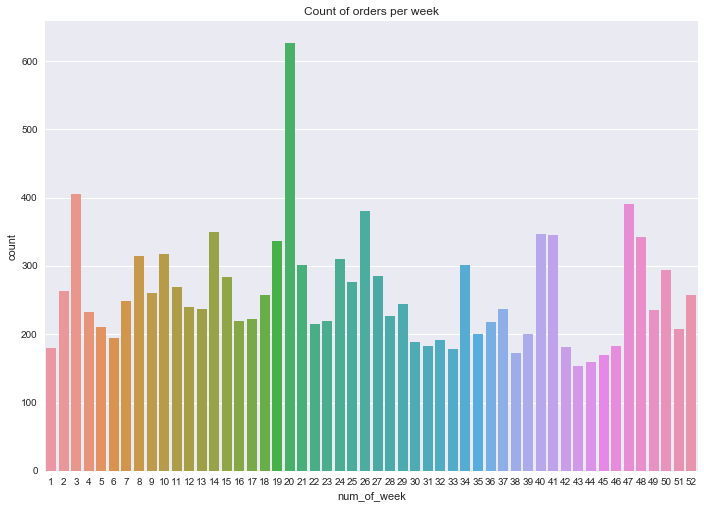

In [19]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.countplot(x = 'num_of_week',data=df2).set_title("Count of orders per week")

### Highest number of orders appears in week 20

# C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant?

### To calculate the significant, we need to do hypothesis testing. Large sample sizes studies use the standard normal z-score statistics. Suppose mean1 = the mean order value when gender is 0 and mean2 = the mean order value when gender is 1

### Here is my null hypothesis:  
### H0 : mean1 = mean2
### H1 : mean1 != mean2

In [20]:
df3 = data
df3.groupby('gender')['value'].mean()

gender
0    363.890006
1    350.708361
Name: value, dtype: float64

In [21]:
df3.groupby('gender')['value'].count()

gender
0    6759
1    6712
Name: value, dtype: int64

In [22]:
df3.groupby('gender')['value'].std()

gender
0    396.533215
1    377.504737
Name: value, dtype: float64

### Calculate z score

In [23]:
from scipy.stats import norm
import numpy as np
def zscore(n1, n2, std1, std2, mean1, mean2):
    pool_std = np.sqrt( (std1**2 /n1) + (std2**2/n2) )
    return (mean1 - mean2)/ pool_std
    
zscore = zscore(6759, 6712, 396.533215, 377.504737, 363.89, 350.7)
zscore

1.977360497323747

### Z score is equal to 1.977. After checking the z table, we realize p value is equal to 0.024. So we can reject the null hypothesis. Therefore, the difference is significant

# D) Assuming a single gender prediction was made for each customer, generate a confusion matrix for predicted gender. What does the confusion matrix tell you about the quality of the predictions?

In [25]:
from sklearn.metrics import confusion_matrix
y_predicted = data['predicted_gender'].values
y_test = data['gender'].values
cm = confusion_matrix(y_test, y_predicted)
print(cm)

[[3349 3410]
 [1463 5249]]


### From this confusion matrix and ROC graph below, the misclassification rate is (FP+FN)/total = (3410+1463) / (5249+3349+3410+1463) = 0.36, the accuracy rate is (TP+TN)/total = (5249+3349)/(5249+3349+3410+1463) = 0.638

### Therefore, the predicted gender is not accurate enough and the quality of predictions is not good.

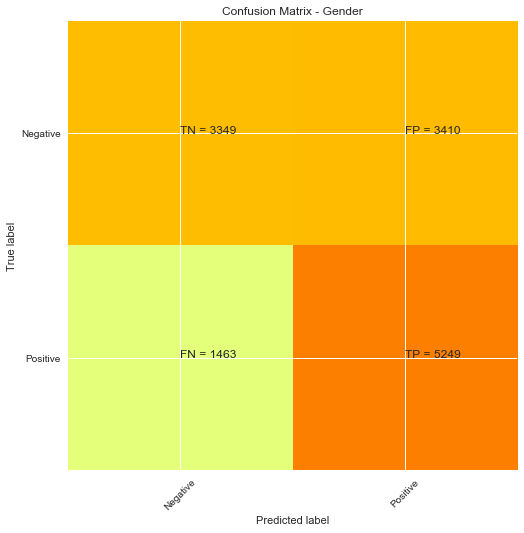

In [26]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Gender')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


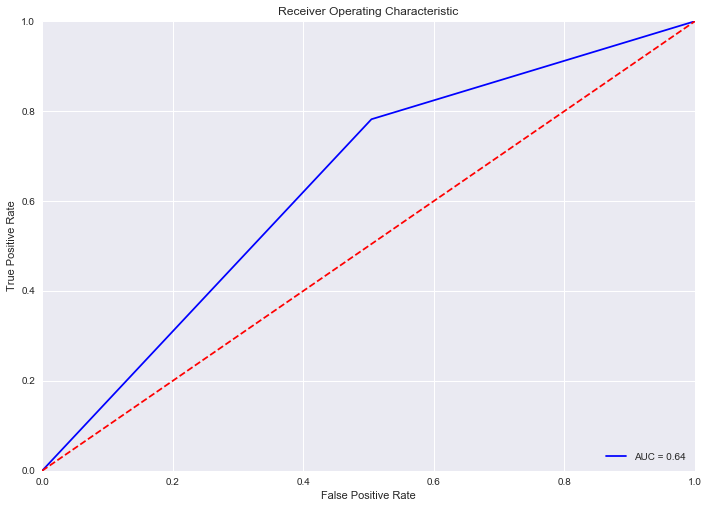

In [27]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# E) Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph.

### For me, compared to scikit-learn random forest algorithm, I prefer to use XGBOOST model, which can reach decent accuracy rate in Kaggle competition. 

### The run times have been much faster than scikit-learn in my experience. XGBOOST use parallelization of tree construction using all of CPU cores during training, which is actually an advantage of tree-based algorithms. 

### For example, I use the Titantic dataset and simply predict gender using XGBOOST.

In [28]:
import pandas as pd

titanic = pd.read_csv('../Titanic.csv')

X = titanic[['Pclass', 'Age', 'Sex']]
y = titanic['Survived']

X['Age'] = X['Age'].fillna(X['Age'].mean())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
X_train['Sex'] = X_train['Sex'].map({'male':0,'female':1})
X_test['Sex'] = X_test['Sex'].map({'male':0,'female':1})

from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
print('The accuracy of eXtreme Gradient Boosting Classifier on testing set:', xgbc.score(X_test, y_test))


The accuracy of eXtreme Gradient Boosting Classifier on testing set: 0.8385650224215246


/Users/glen/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### The accuracy of eXtreme Gradient Boosting Classifier on testing set is 83.8%